In [1]:
'''
para evitar que se ponga en off, hacer ctrol + shift + i y luego a consola
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
'''

'\npara evitar que se ponga en off, hacer ctrol + shift + i y luego a consola\nfunction ConnectButton(){\n    console.log("Connect pushed"); \n    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() \n}\nsetInterval(ConnectButton,60000);\n'

In [2]:
import sys
sys.prefix

'c:\\Users\\RomanGu\\OneDrive - BASF\\Documents\\CODE\\tfmfresh'

In [3]:
!type ..\requirements\pytorch_requirements.txt

transformers
torch
numpy
pandas
seaborn
matplotlib
scikit-learn
watermark
psutil
IProgress
sympy
filelock
jinja2
networkx
typing-extensions
IProgress 
awscli


In [4]:
# !nvidia-smi --force-reinstall
!!pip install -qq -r ..\requirements\pytorch_requirements.txt
# !pip install sympy


[]

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [5]:
# !pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f
# !pip install -qq transformers torch pandas psutil scikit-learn 
# !pip install -qq -U watermark seaborn
# !where python

In [6]:
!pip show torch

Name: torch
Version: 2.0.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: c:\users\romangu\onedrive - basf\documents\code\tfmfresh\lib\site-packages
Requires: filelock, jinja2, networkx, sympy, typing-extensions
Required-by: 


In [7]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

c:\Users\RomanGu\OneDrive - BASF\Documents\CODE\tfmfresh\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python implementation: CPython
Python version       : 3.8.1
IPython version      : 8.12.2

numpy       : 1.24.3
pandas      : 2.0.1
torch       : 2.0.1
transformers: 4.29.2



In [8]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch,os

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import os

if not os.path.exists('./sample_data'):
    os.makedirs('./sample_data')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# seleccionamos la GPU si está disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## CONFIGURACIÓN DE LOS MODELOS PREENTRENADOS BERT

>CONSULTAR LOS MODELOS PREENTRENADOS DISPONIBLES [AQUI](https://huggingface.co/transformers/pretrained_models.html)



In [9]:
def experimento(tipo: str, idioma: str):
  if tipo.upper()=="A":
    BATCH_SIZE = 16
    EPOCHS = 2
    LEARNING_RATE = 5e-5
  elif tipo.upper()=="B":
    BATCH_SIZE = 32
    EPOCHS = 4
    LEARNING_RATE = 3e-5
  else:
      print("elige experimento")
  
  if idioma.upper()=="EN":
    PRE_TRAINED_MODEL_NAME = 'google/bert_uncased_L-4_H-256_A-4'
  elif idioma.upper()=="ES":
    PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
  else:
    print("modelo no elegido")
  return BATCH_SIZE, EPOCHS, LEARNING_RATE,PRE_TRAINED_MODEL_NAME



In [10]:
BATCH_SIZE, EPOCHS, LEARNING_RATE, PRE_TRAINED_MODEL_NAME = experimento(tipo = "a", idioma ="es")
# Original values
# LEARNING_RATE = 2e-5
# BATCH_SIZE = 32
# PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
# PRE_TRAINED_MODEL_NAME = 'google/bert_uncased_L-4_H-256_A-4'

print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"LEARNING_RATE: {LEARNING_RATE}")
print(f"EPOCHS: {EPOCHS}")
print(f"PRE_TRAINED_MODEL_NAME: {PRE_TRAINED_MODEL_NAME}")

BATCH_SIZE: 16
LEARNING_RATE: 5e-05
EPOCHS: 2
PRE_TRAINED_MODEL_NAME: bert-base-multilingual-cased


## Data Exploration



### download data

In [11]:
!pip install awscli
!aws s3 cp s3://amazon-reviews-ml/json/test/dataset_es_test.json ./sample_data/ --no-sign-request
!aws s3 cp s3://amazon-reviews-ml/json/train/dataset_es_train.json ./sample_data/ --no-sign-request

Completed 256.0 KiB/1.8 MiB (173.0 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/1.8 MiB (302.0 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/1.8 MiB (411.1 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/1.8 MiB (533.7 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/1.8 MiB (540.6 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/1.8 MiB (648.1 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/1.8 MiB (755.8 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/1.8 MiB (798.5 KiB/s) with 1 file(s) remaining  
download: s3://amazon-reviews-ml/json/test/dataset_es_test.json to sample_data\dataset_es_test.json
Completed 256.0 KiB/73.9 MiB (175.4 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/73.9 MiB (328.8 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/73.9 MiB (486.8 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/73.9 MiB (644.6 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/73.9 MiB (793.1 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/73.9 M

In [12]:
!ls ./sample_data

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [13]:

# Si queremos hacer el split al dataset
'''
(trainingData, testData) = trainDataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
'''

'\n(trainingData, testData) = trainDataset.randomSplit([0.7, 0.3], seed = 100)\nprint("Training Dataset Count: " + str(trainingData.count()))\nprint("Test Dataset Count: " + str(testData.count()))\n'

In [14]:
root_folder = "./sample_data/"

traindata = root_folder + "dataset_es_train.json"
testdata = root_folder + "dataset_es_test.json"


In [15]:
!head {traindata}

'head' is not recognized as an internal or external command,
operable program or batch file.


In [16]:
# from google.colab import data_table
import json 
df = pd.read_json(traindata,lines=True)[["stars",	"review_body"]].rename(columns={"review_body": "description"})
df_testdata = pd.read_json(testdata,lines=True)[["stars",	"review_body"]].rename(columns={"review_body": "description"})
print("Tamaño total ",df.shape)
# data_table.DataTable(df, include_index=False, num_rows_per_page=10)
df[:10]

Tamaño total  (200000, 2)


,stars,description
0,1,Nada bueno se me fue ka pantalla en menos de 8...
1,1,"Horrible, nos tuvimos que comprar otro porque ..."
2,1,Te obligan a comprar dos unidades y te llega s...
3,1,"No entro en descalificar al vendedor, solo pue..."
4,1,Llega tarde y co la talla equivocada
5,1,Jamás me llegó y el vendedor nunca contacto co...
6,1,"El paraguas es de muy mala calidad,da la sensa..."
7,1,Tuve que devolverla porque al ser triangular n...
8,1,Estoy esperando despues de protestar varias ve...
9,1,"Defectuoso. En apariencia muy bien producto, p..."


# Creando las categorías del sentiment en base al numero de estrellas:
- Negative
- Neutral
- Positive

In [19]:

df["sentiment"]= np.select([df['stars'].between(0, 2, inclusive='neither'), df['stars']==3], 
    ['negative', 'neutral'],
    default="positive")

df_testdata["sentiment"]= np.select([df_testdata['stars'].between(0, 2, inclusive='neither'), df_testdata['stars']==3], 
    ['negative', 'neutral'],
    default="positive")


In [20]:
df_testdata[:5]

,stars,description,sentiment
0,1,no me llego el articulo me lo mando por correo...,negative
1,1,"la mensajería horrible, no compro mas",negative
2,1,Estoy muy decepcionado con el vendedor ya que ...,negative
3,1,Mi valoración no es sobre el producto sino sob...,negative
4,1,Pues tenía interés en este libro y probé la ve...,negative


In [21]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df["category_encoded"]=le.fit_transform(df.sentiment)
df_testdata["category_encoded"]=le.fit_transform(df_testdata.sentiment)

In [22]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [24]:
!pip show pandas

Name: pandas
Version: 2.0.1
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: 
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License
        
        Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
        All rights reserved.
        
        Copyright (c) 2011-2023, Open source contributors.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        * Redistributions of source code must retain the above copyright notice, this
          list of conditions and the following disclaimer.
        
        * Redistributions in binary form must reproduce the above copyright notice,
          this list of conditions and the following disclaimer in the documentation
          and/or other materials provided with the distrib

In [25]:
# igualamos el numero de ocurrencias por categoria para no tener bias.
# df_temp = (
#     df.query("sentiment=='negative'")[:40000]
#     .append(df.query("sentiment=='neutral'")[:40000])
#     .append(df.query("sentiment=='positive'")[:40000])
# )
# df_testdata_temp = (
#     df_testdata.query("sentiment=='negative'")[:1000]
#     .append(df_testdata.query("sentiment=='neutral'")[:1000])
#     .append(df_testdata.query("sentiment=='positive'")[:1000])
# )
df_temp = pd.concat([
    df.query("sentiment=='negative'")[:40000],
    df.query("sentiment=='neutral'")[:40000],
    df.query("sentiment=='positive'")[:40000]
], ignore_index=True)

df_testdata_temp = pd.concat([
    df_testdata.query("sentiment=='negative'")[:1000],
    df_testdata.query("sentiment=='neutral'")[:1000],
    df_testdata.query("sentiment=='positive'")[:1000]
], ignore_index=True)


In [26]:
df = df_temp
df_testdata = df_testdata_temp
df.sentiment.value_counts().where(lambda x: x>1).dropna()

sentiment
negative    40000
neutral     40000
positive    40000
Name: count, dtype: int64

In [27]:
df_testdata.sentiment.value_counts().where(lambda x: x > 1).dropna()

sentiment
negative    1000
neutral     1000
positive    1000
Name: count, dtype: int64

<Axes: xlabel='sentiment'>

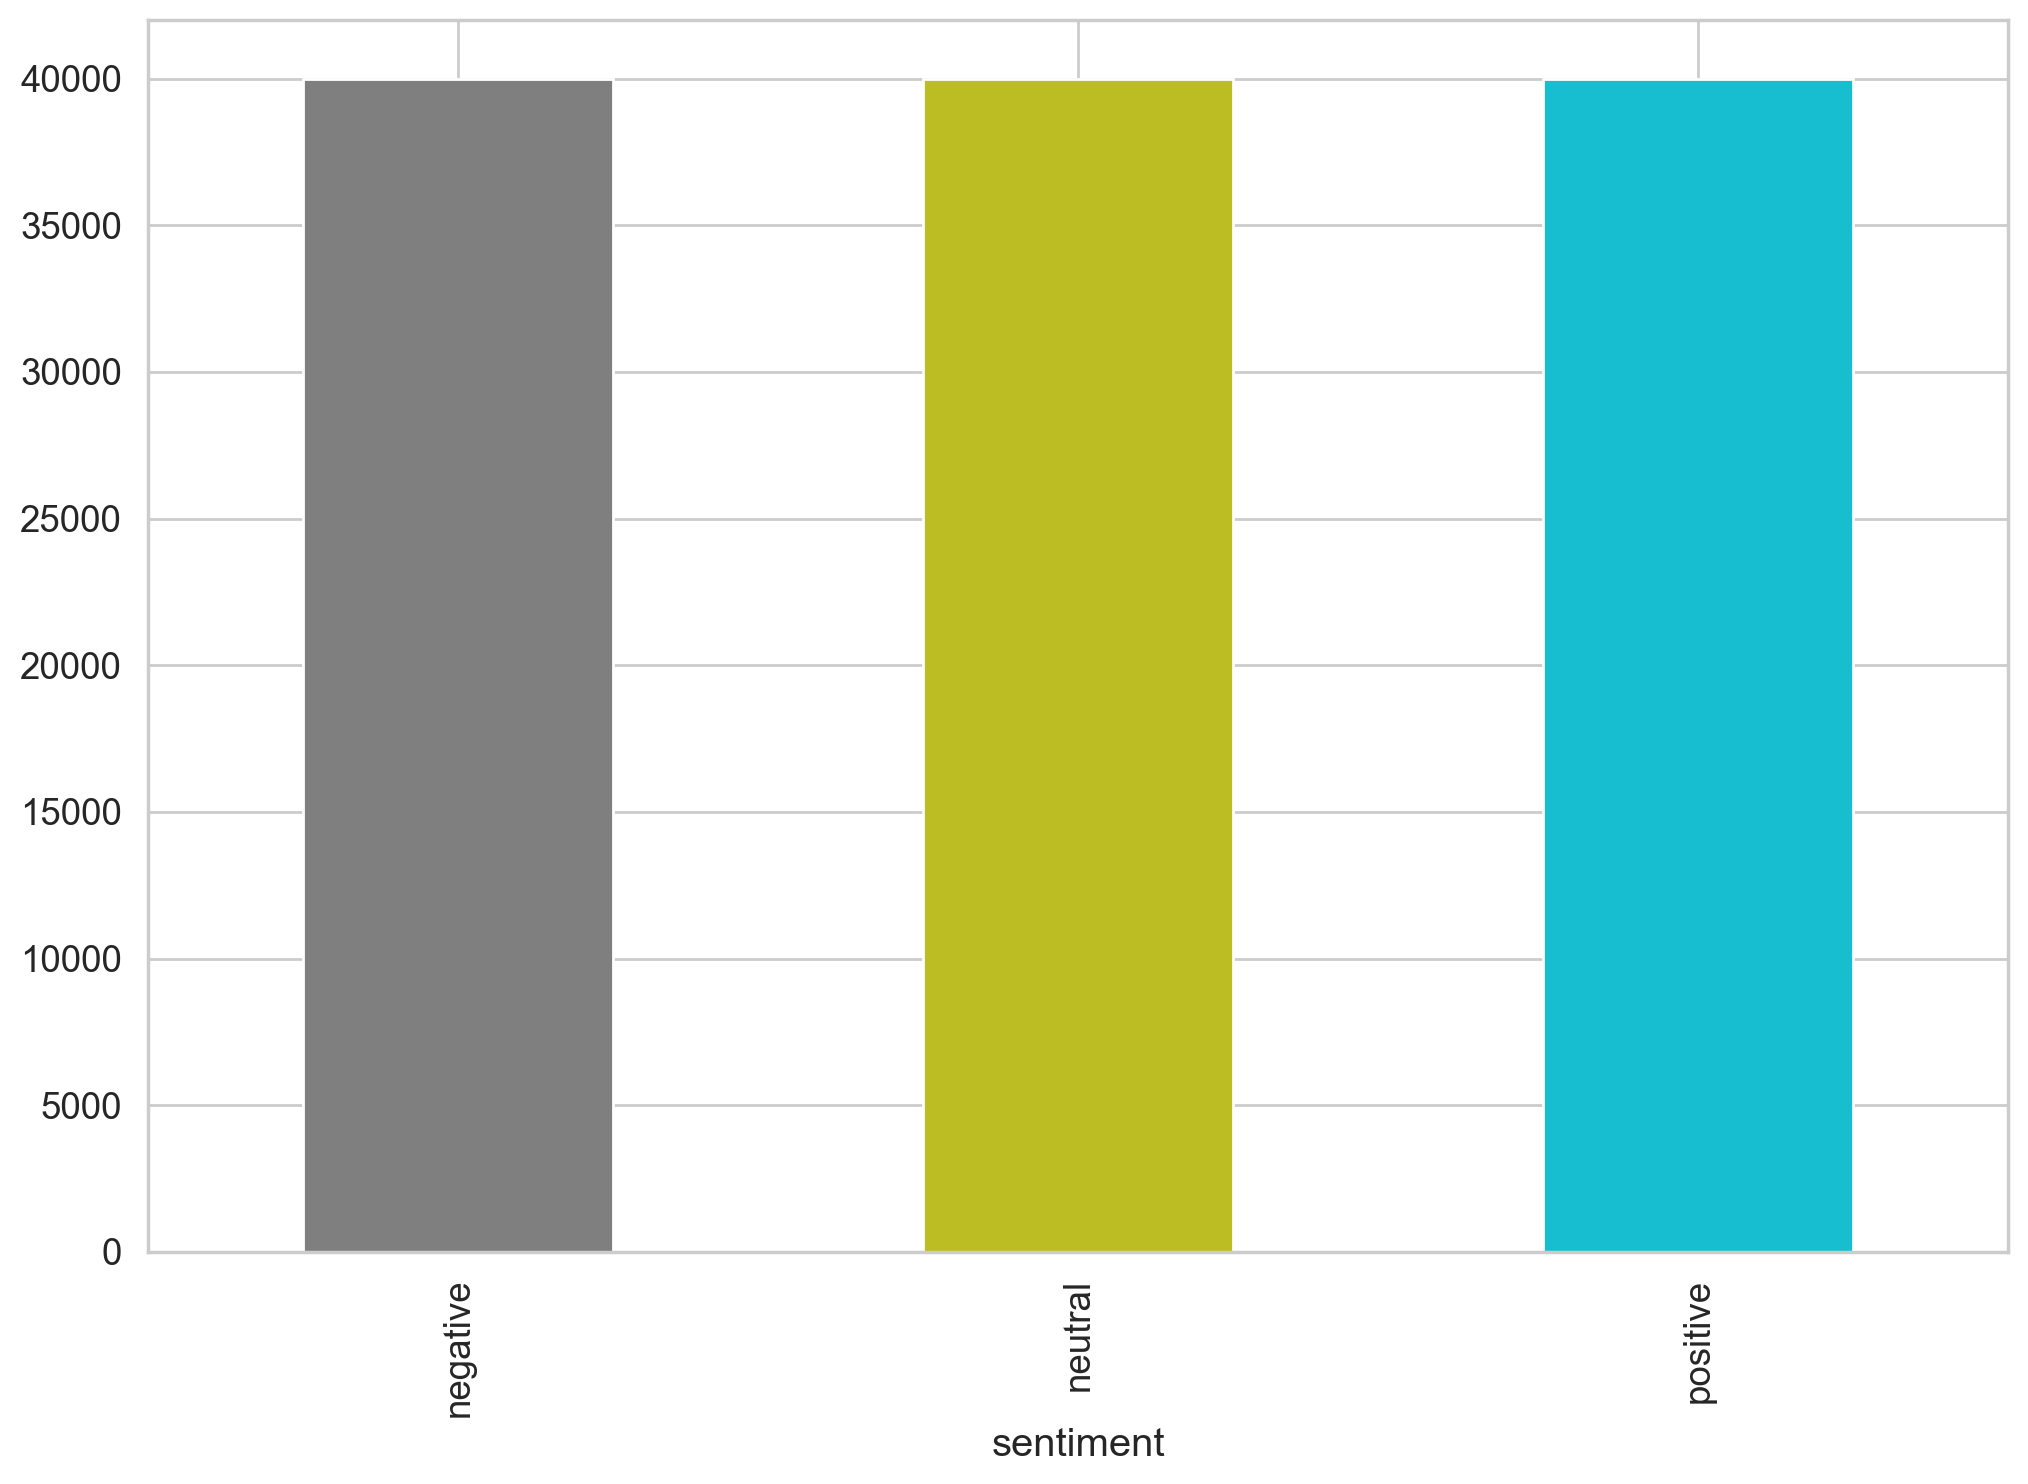

In [29]:
colors = [
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
    "#1a55FF",
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
]
df.sentiment.value_counts().where(lambda x: x > 1000).dropna().plot.bar(color=colors)

In [30]:
# creamos tokenizador bert
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

c:\Users\RomanGu\OneDrive - BASF\Documents\CODE\tfmfresh\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\RomanGu\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [31]:
# frase ejemplo 
sample_txt = 'Cuanto fue la ultima vez que salí? Me quedé encerrado en casa dos semanas.'
# ejemplo tokenización manual (separando x listas )
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Cuanto fue la ultima vez que salí? Me quedé encerrado en casa dos semanas.
   Tokens: ['Cu', '##anto', 'fue', 'la', 'ultima', 'vez', 'que', 'sal', '##í', '?', 'Me', 'que', '##dé', 'en', '##cer', '##rado', 'en', 'casa', 'dos', 'semanas', '.']
Token IDs: [34387, 41167, 10553, 10109, 20371, 11675, 10121, 31119, 10545, 136, 11589, 10121, 29239, 10110, 17505, 18781, 10110, 12088, 10398, 33972, 119]


In [32]:
# Mismo ejemplo pero preparandolo para Pytorch (tensors) con encode_plus

sample_txt = "'Los medicos entregan a Freeman 'Devastado' y encuentran los escaneres cerebrales computerizados.'"

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Añadir '[CLS]' & '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Devolver PyTorch tensors
)

encoding.keys()


dict_keys(['input_ids', 'attention_mask'])

In [33]:
# para ver los tokens (convertirlo a algo legible)
print(f"--->longitud tokens: {len(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]) )}")
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]) 

--->longitud tokens: 32


['[CLS]',
 "'",
 'Los',
 'medico',
 '##s',
 'entrega',
 '##n',
 'a',
 'Freeman',
 "'",
 'Dev',
 '##asta',
 '##do',
 "'",
 'y',
 'encuentran',
 'los',
 'es',
 '##can',
 '##eres',
 'cerebral',
 '##es',
 'computer',
 '##izados',
 '.',
 "'",
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Eligiendo la longitud de la secuencia (Sequence Length)

BERT funciona bien con secuencias de igual tamaño (longitud). Se usa una estrategia simple para elegir la longitud maxima. 

Veamos la longitud de los tokens para cada review

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\RomanGu\AppData\Local\Temp\ipykernel_22840\192746740.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


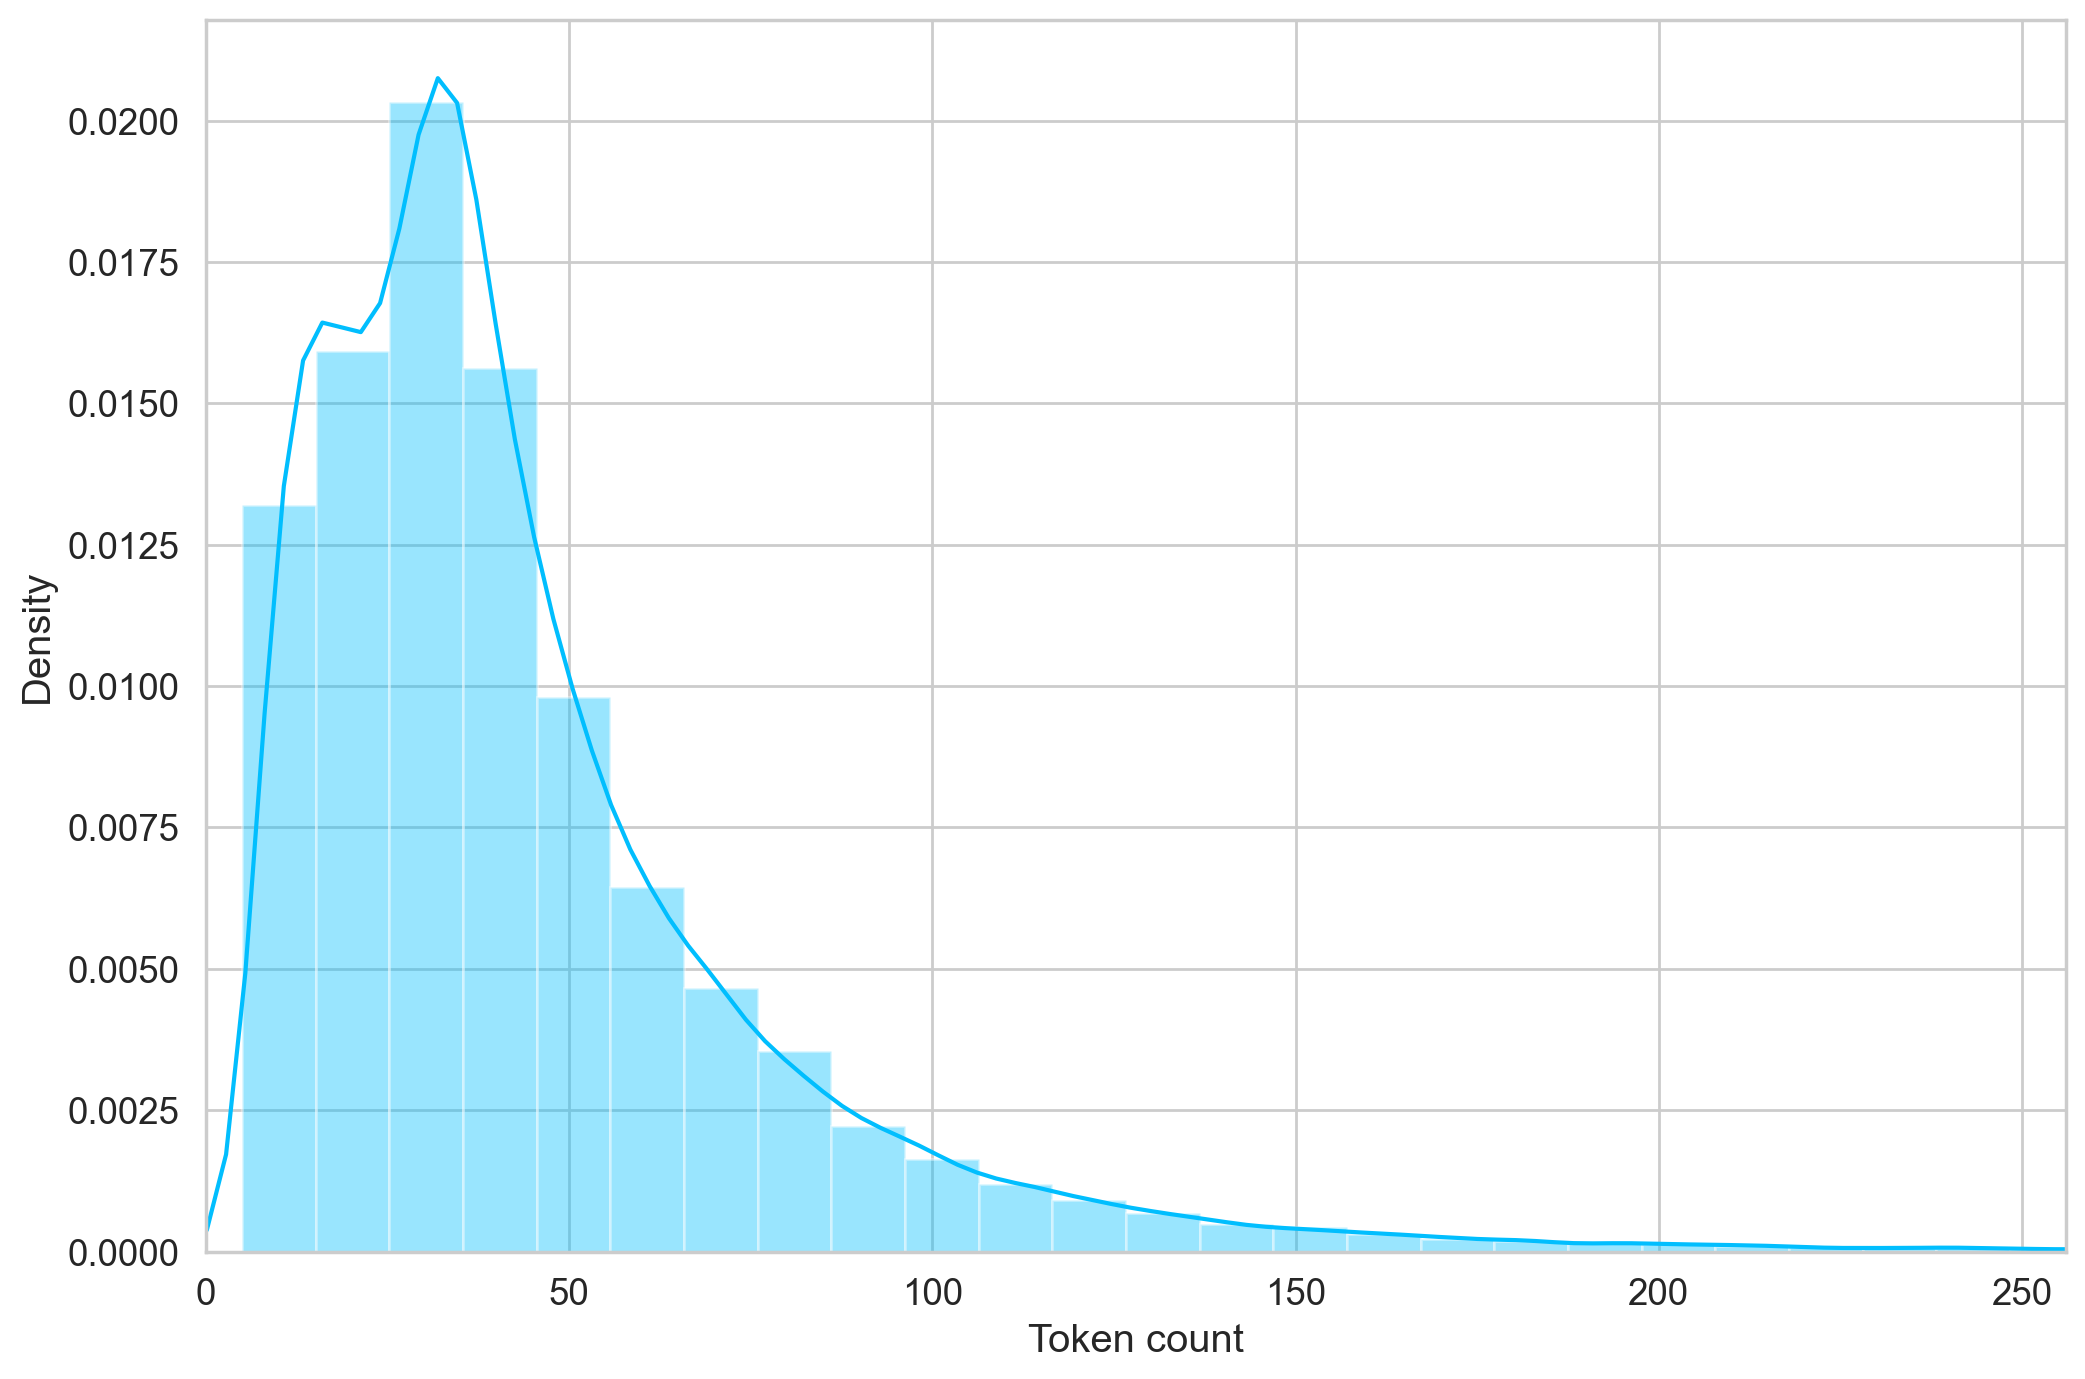

In [34]:
token_lens = []

for txt in df.description:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
# lo visualizamos para hacernos una idea
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

# vemos a ojo el numero de tokens.
# y asignamos un valor

In [36]:
# valor para el numero de tokens por lote (ALGO RAZONABLE 160)
MAX_LEN = 150

# Construir el dataset y dataloader

In [37]:
# construimos dataloader
class GPReviewDataset(Dataset):
  # definimos las variables de iniciación con los datos.
  def __init__(self, text_toclasify, targets, tokenizer, max_len):
    self.reviews = text_toclasify # el texto a clasificar
    self.targets = targets # el topic/sentiment/objetivo.
    self.tokenizer = tokenizer # el objeto tokenizer de Huggingface o transformación aplicada a los datos
    self.max_len = max_len # numero de tokens por frase
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    # configuración del tokenizador.
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #pad_to_max_length=True,
      # lets try with:
      truncation=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    # devolvemos un diccionario con los input codificados.
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

## Train-test split

In [38]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
# aqui añado los datos csv del segundo dataset `testdata`
df_val, df_test2 = train_test_split(df_testdata, test_size=0.5, random_state=RANDOM_SEED)

In [39]:
# df_train.shape, df_val.shape, df_test.shape

print("Training Dataset shape: " + str(df_train.shape))
print("Evaluation Dataset shape: " + str(df_val.shape))
print("Test Dataset shape: " + str(df_test.shape))

Training Dataset shape: (108000, 4)
Evaluation Dataset shape: (1500, 4)
Test Dataset shape: (12000, 4)


In [40]:
def create_data_loader(df,col_text,col_targets,  tokenizer, max_len, batch_size):
  '''
  df: nombre del dataframe,
  col_text: columna que contiene el texto a procesar,
  col_targets: columna con las etiquetas.
  max_len: el numero de token por frase, 
  batch_size: el numero de frases por lote.
  '''
  ds = GPReviewDataset(
    text_toclasify=df[col_text].to_numpy(),
    targets=df[col_targets].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    # Antes el numero de workers era num_workers=4, pero para optimizar mejor el rendimiento el sistema pide 2
    num_workers=2
  )

In [41]:
df.columns

Index(['stars', 'description', 'sentiment', 'category_encoded'], dtype='object')

In [42]:
### HAY QUE HACER ONE HOT ENCODING PARA PODER METERLO EN EL BERT

In [43]:
train_data_loader = create_data_loader(df_train, "description","category_encoded", tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val,"description","category_encoded",tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test,   "description","category_encoded",tokenizer, MAX_LEN, BATCH_SIZE)

In [44]:
# vemos la estructura de un batch para el training
data = next(iter(train_data_loader))
data.keys()

In [ ]:
print("keys train dataset",data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

keys train dataset dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [ ]:
data = next(iter(val_data_loader))
print("keys evaluation dataset",data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

keys evaluation dataset dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [ ]:
# cargamos el modelo BERT
#creamos un clasificador BERT para realizar clasificaciones
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__() # hereda propiedades y methods de otras clases. llama al init de otra clase.
    # Cuando creamos nuestro modelo, podemos elegir el modelo base o pillar BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3) # dropout layer
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      # es necesario añadirlo despues del cambio de la v3 a la v4
      return_dict=False 
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
class_names=le.classes_
# print(f"Numero de cagetorias: {len(class_names)}")
print(f"Numero de cagetorias: {len(le.classes_)}")

Numero de cagetorias: 3


## asignamos el modelo

In [ ]:
# asignamos el modelo a un objeto, le pasamos como argumento el countdistinct de todas las etiquetas que tenemos.
# y lo movemos a la memoria de la GPU

model = SentimentClassifier(len(le.classes_))
model = model.to(device)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training

Para reproducir el procedimiento de entrenamiento del **documento BERT**  usaremos el optimizador [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) de Hugging Face. Corregirá el reparto/decadencia de pesos (weight decay), para que sea similar al documento original.  Tambien usaremos un planificador lineal (para la curva de aprendizaje) sin steps de calentamiento (warmup steps). 

In [ ]:
# EPOCHS = 4 # 10
# LEARNING_RATE = 2e-5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# la funcion de perdida en este caso es entropia cruzada, que combina LogSoftMax y NLLLoss en una sola clase. Muy utilizada en ML y concretamente en clasificación multietiqueta. 
loss_fn = nn.CrossEntropyLoss().to(device)

¿Cómo llegamos a la conclusion de usar este numero de hiperparámetros? Los autores de BERT tienen algunas recomendaciones para el ajuste fino: 

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

Vamos a ignorar la recomendación del numero de "vueltas" *epochs* pero nos quedamos con el resto. A tener en cuenta, que al aumentar el tamaño del lote (batch size) se reduce significativamente el tiempo de entrenamiento a costas de una menor precision (lower accuracy).

Escribimos una funcion auxiliar que nos ayude a entrenar nuestro modelo solo una vuelta.

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  # aqui el Scheduler se llama cada vez que se alimenta otro lote (d) al modelo.
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    # outputs del modelo 
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    # 
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    # con clip_grad_norm normalizamos los parametros del modelo evitando Gradient exploding
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

# Evaluar el modelo
funcion para evaluar el modelo y luego crear loop

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

### loop de entrenamiento

In [ ]:
%%time

history = defaultdict(list)# creamos un diccionario de listas vacio, para añadir las vueltas
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  # almacenamos el mejor estado del modelo 
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.3266758765876293 accuracy 0.8873960628900536
Val   loss 0.2985817668255137 accuracy 0.8955263157894736
Epoch 2/4
----------
Train loss 0.24869657614937535 accuracy 0.914766940128521
Val   loss 0.2776578267832764 accuracy 0.9071052631578947
Epoch 3/4
----------
Train loss 0.21921244114471805 accuracy 0.9250449082390415
Val   loss 0.2708842696293312 accuracy 0.9107894736842105
Epoch 4/4
----------
Train loss 0.20239636412538864 accuracy 0.9317116983647846
Val   loss 0.2680794372685066 accuracy 0.9134210526315789
CPU times: user 24min 39s, sys: 13.3 s, total: 24min 53s
Wall time: 25min 42s


In [ ]:
if not os.path.exists('./modelos'):
    os.makedirs('./modelos')

In [ ]:
# si el modelo es de nuestro agrado podemos guardarlo en drive
import datetime
import os
startdate=str(datetime.datetime.now())
startdate=startdate.replace(' ','_').replace(':','').replace('-','').replace('.','_')

ruta_guardado = os.path.join('./modelos',startdate+"_"+'bert_model_state.bin')
# !cp {'best_model_state.bin'} {ruta_guardado}

'/content/gdrive/MyDrive/modelos/20210713_144247_503393_best_model_state.bin'

Ahora podemos ver el historial de entrenamiento Vs la precisión de la validación.

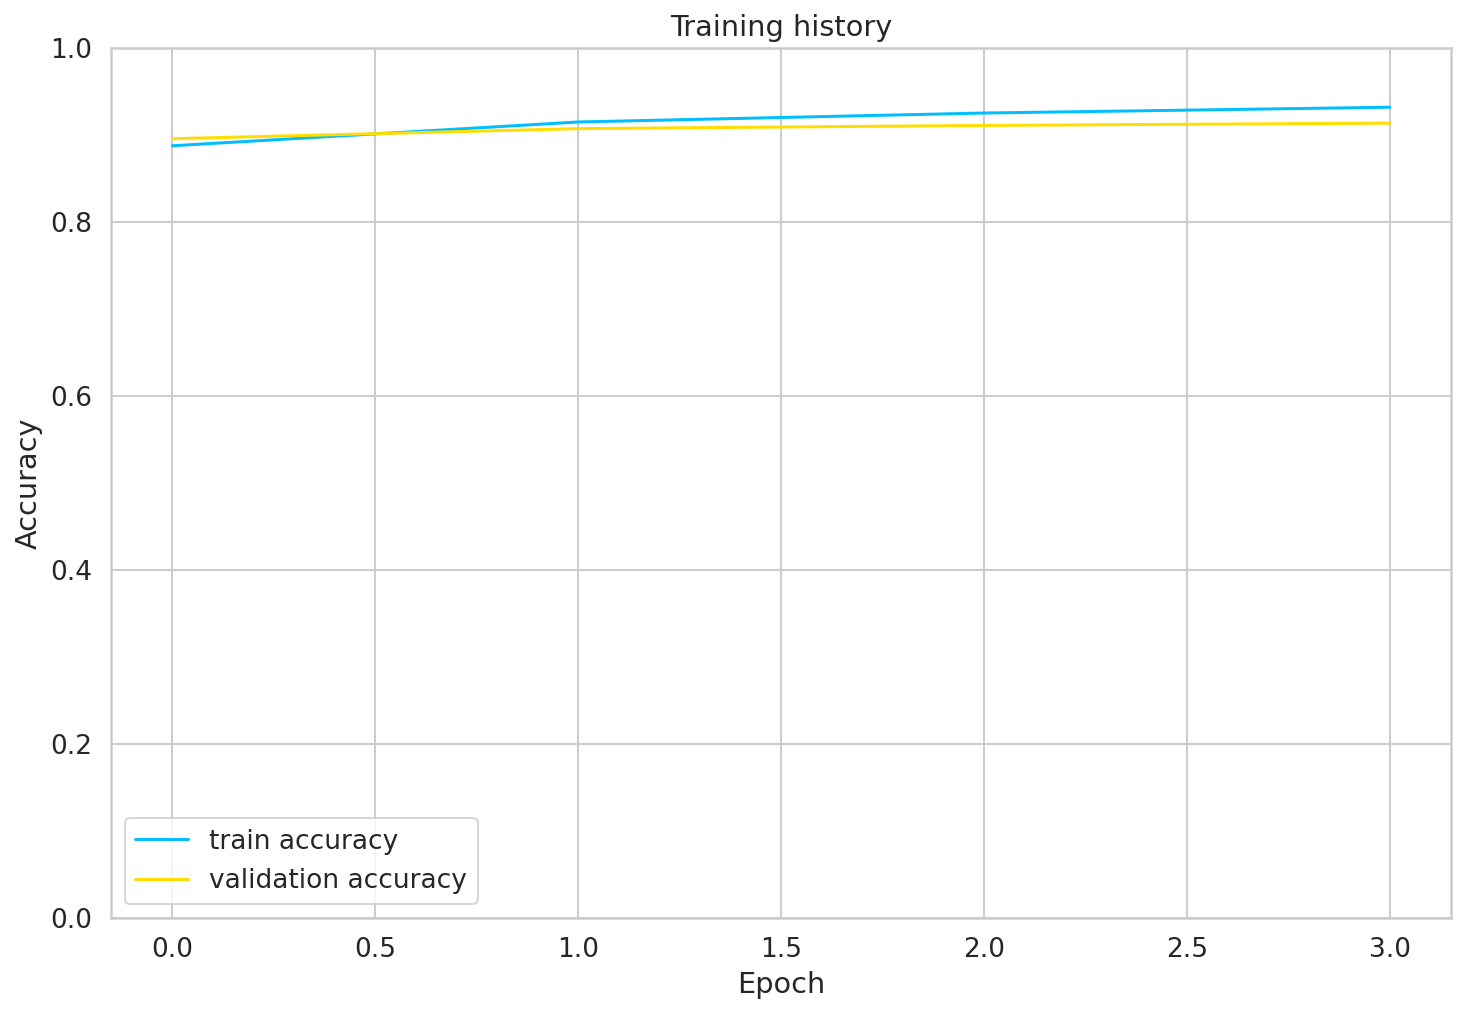

In [ ]:
plt.plot(history['train_acc'], label='train accuracy') # precisión de entrenamiento
plt.plot(history['val_acc'], label='validation accuracy') # precisión de validación.

plt.title('Historial de entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluacion
Como sabemos que nuestro modelo está prediciendo bien? Se empieza calculando la precisión en nuestro set de prueba.

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.91875

La precisión es casi un 1% mas baja que en la de validación. Nuestro modelo parece generalizar bien.

Este modelo con tan solo 40MB de peso y 4 epochs nos ha permitido alcanzar casi un 90% de accuracy en menos de 30 min utilizando GPU.

Definamos una función para ayudarnos a tomar predicciones de nuestro modelo:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

Esto es similar a la función de evaluación, excepto que almacenamos el texto de las Reviews y las predicciones. (aplicando la función softmax en la salida del modelo):


In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Veeamos el informe de la clasificación.

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

    Business       0.90      0.86      0.88      3018
    Sci/Tech       0.88      0.90      0.89      3039
      Sports       0.97      0.98      0.97      2976
       World       0.93      0.93      0.93      2967

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



VER SI ESTA EVALUANDO CORRECTAMENTE.

La matriz de confusión:

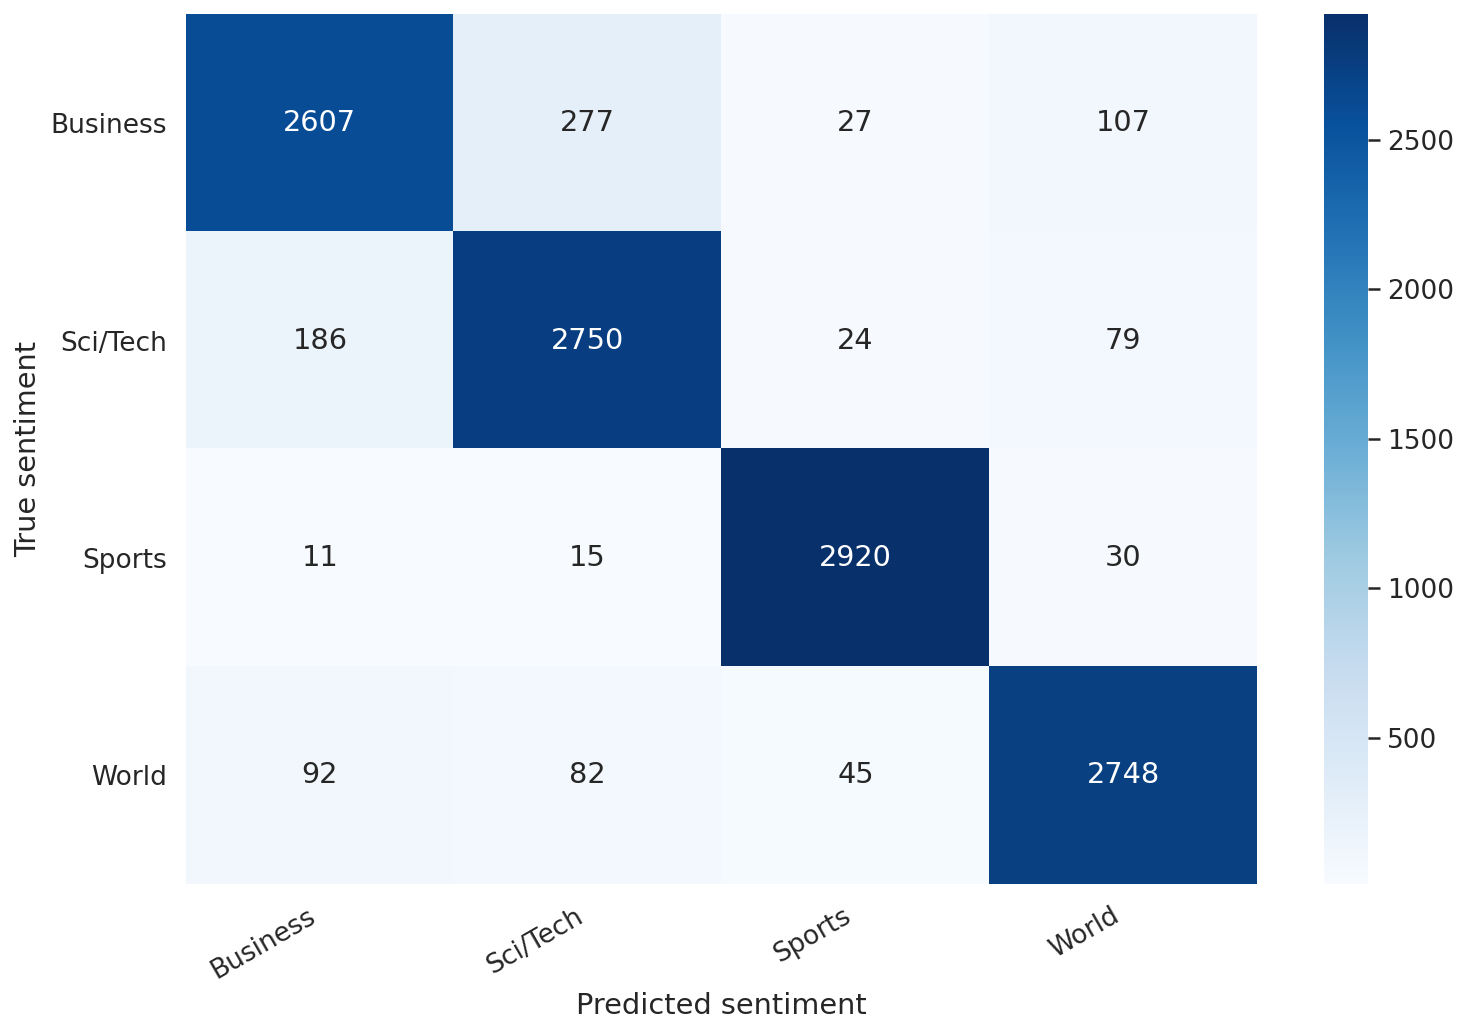

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True category')
  plt.xlabel('Predicted category');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
## VER AQUI FALSOS POSITIVOS Y AJUSTE
'''
Como podemos observar, al modelo le cuesta diferenciar entre ciencia y tecnología\n
y Negocios, estas categorias agrupan la mayor concentración de falsos positivos.
'''

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_category = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True category: {class_names[true_category]}')

GREEN BAY, WIS. - Lovie Smith did not take long to fulfill his No. 1
goal of beating Green Bay. But the man who helped him do it wasn #39;t
around afterward to celebrate.

True classification: Sports


Ahora podemos mirar la confianza de cada clasificación de nuestro modelo:

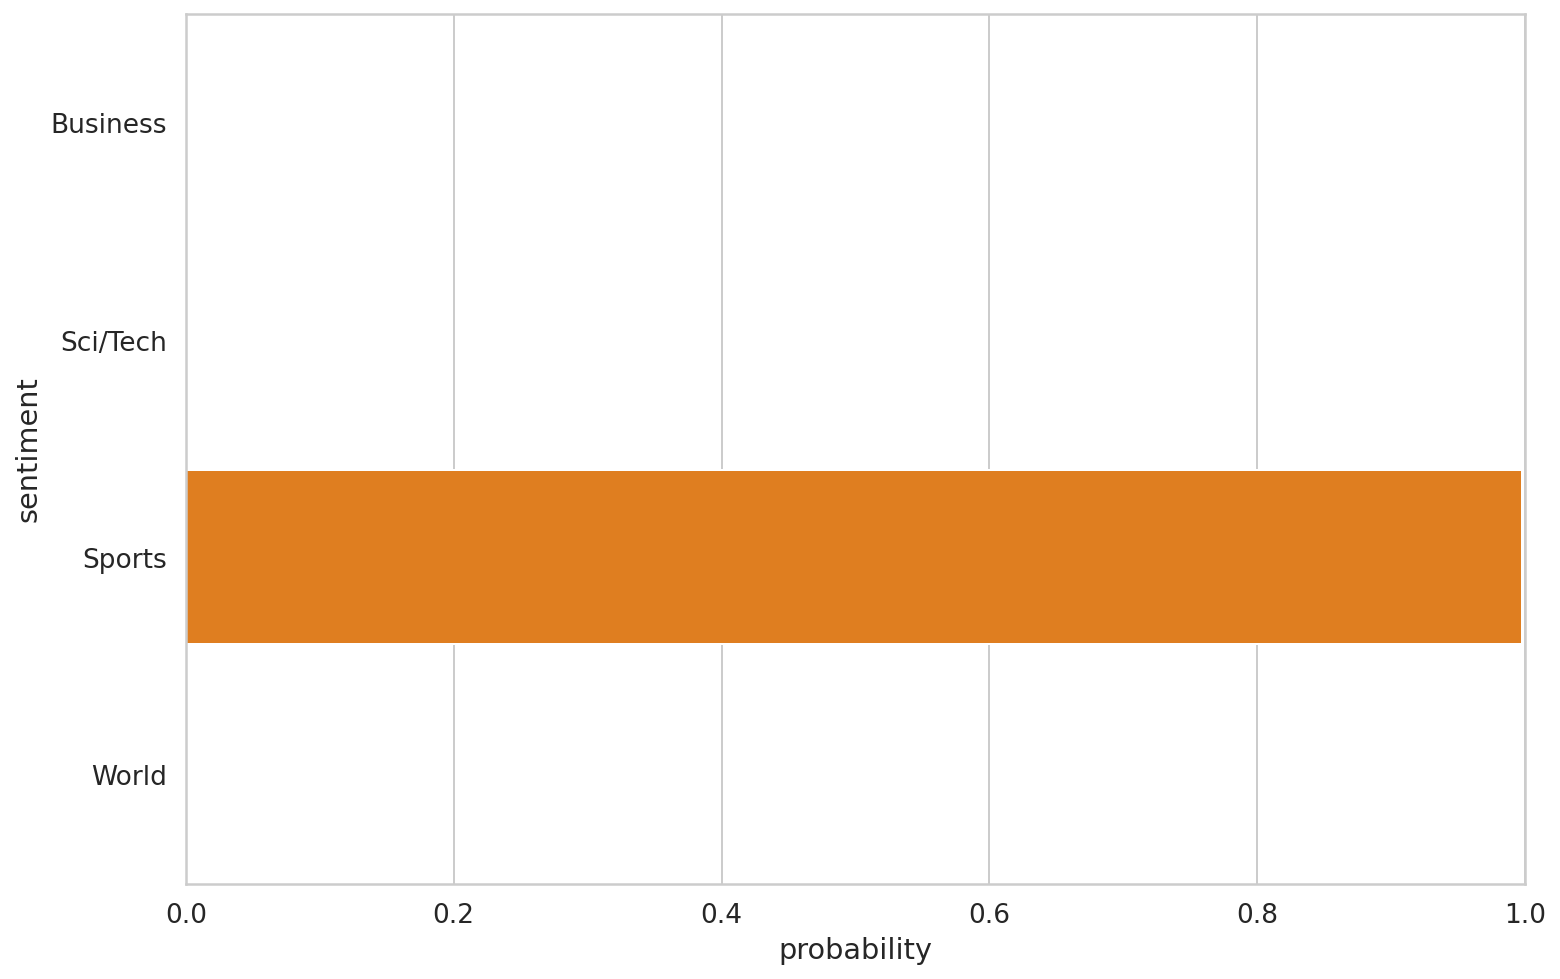

In [ ]:
# VER LA CONFIANZA DE LA PREDICCIÓN DEL EJEMPLO ANTERIOR.
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('category')
plt.xlabel('probability')
plt.xlim([0, 1]);